# Upsale

The issue consist of predicting a certain type of package for Sberbank clients based on a few dozen features.

There are 5 possible packages
1. `ЛЕГКИЙ СТАРТ` (free)
2. `УДАЧНЫЙ СЕЗОН` (paid)
3. `ХОРОШАЯ ВЫРУЧКА` (paid)
4. `АКТИВНЫЕ РАСЧЕТЫ` (paid)
5. `БОЛЬШИЕ ВОЗМОЖНОСТИ` (paid)

We are interested in suggesting only paid packages, so the training set will include from 2 to 5 packages and test set contains `ЛЕГКИЙ СТАРТ` only

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import ipywidgets

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 37)
pd.set_option('display.max_rows', 100)

The content contains 2 paragraphs:
1. Feature Engineering (download and preparation data from different sources such as ISKRA and SAS for the next analysis)
2. Data preprocessing and Machine Learning

## 1. Feature Engineering

### 1.1. ISKRA

#### 1.1.1. main_vitr

Data contains type of package for each account of the client

In [ ]:
main_vitr = pd.read_csv('./data/main_vitrina', sep=';', encoding='cp1251', usecols=['TB', 'GOSB', 'INN', 'ACC',
                        'DATE_OPEN', 'C_NAME', 'DATE_BEGIN'])
main_vitr.drop_duplicates(inplace=True)

This TB should be ommited due to their closure

In [ ]:
main_vitr = main_vitr[~main_vitr['TB'].isin(['Западно-Уральский банк', 'Северный банк'])]

There should be only 5 packages which emerge since October 2017

In [ ]:
main_vitr = main_vitr[main_vitr['C_NAME'].isin(['ЛЕГКИЙ СТАРТ', 'ХОРОШАЯ ВЫРУЧКА', 'УДАЧНЫЙ СЕЗОН',
                                                'БОЛЬШИЕ ВОЗМОЖНОСТИ', 'АКТИВНЫЕ РАСЧЕТЫ',
                                                'НЕ ИСПОЛЬЗОВАТЬ_БОЛЬШИЕ ВОЗМОЖНОСТИ_ПОСЛЕ 01.08.18'])]
main_vitr.loc[main_vitr['C_NAME'] == 'НЕ ИСПОЛЬЗОВАТЬ_БОЛЬШИЕ ВОЗМОЖНОСТИ_ПОСЛЕ 01.08.18',
              'C_NAME'] = 'БОЛЬШИЕ ВОЗМОЖНОСТИ'
main_vitr.rename(columns={'C_NAME': 'PACKAGE'}, inplace=True)

We are interested in only accounts which belong to commercial organizations and individual enterpreneurs

In [ ]:
main_vitr['INN'] = main_vitr['INN'].astype('str')
main_vitr = main_vitr[main_vitr['INN'].str.contains('^\d{10,}')]
main_vitr = main_vitr[main_vitr['ACC'].str.contains('^40[78]02.*')]

Restrict the date to 2017 and 2018 years and transform the date to the account age

In [ ]:
main_vitr.loc[main_vitr['DATE_BEGIN'].isnull(),
              'DATE_BEGIN'] = main_vitr.loc[main_vitr['DATE_BEGIN'].isnull(), 'DATE_OPEN']
main_vitr['DATE_BEGIN'] = pd.to_datetime(main_vitr['DATE_BEGIN'])
main_vitr['DATE_OPEN'] = pd.to_datetime(main_vitr['DATE_OPEN'])

main_vitr = main_vitr[(main_vitr['DATE_BEGIN'] >= '2017-01-01') & (main_vitr['DATE_BEGIN'] <= pd.Timestamp('now'))]
main_vitr = main_vitr[main_vitr['DATE_OPEN'] <= '2018-10-30']
main_vitr['ACC_AGE'] = (pd.Timestamp('now') - main_vitr['DATE_OPEN']).dt.days
main_vitr.drop('DATE_OPEN', axis=1, inplace=True)

main_vitr.dropna(inplace=True)

In [ ]:
main_vitr['INN'] = main_vitr['INN'].astype('int64')
main_vitr['ACC'] = main_vitr['ACC'].astype('float32')

Group by INN and ACC and sort the date to ascending so as to find the last package

In [ ]:
main_vitr.sort_values(by=['INN', 'ACC', 'DATE_BEGIN'], inplace=True)

main_vitr = main_vitr.groupby(by=('INN', 'ACC'), as_index=False, sort=True).agg({'PACKAGE': ('last', 'count'),
                                                                                 'TB': 'first',
                                                                                 'GOSB': 'first',
                                                                                 'ACC_AGE': 'first'})

In [ ]:
main_vitr.columns = ['INN', 'ACC', 'TB', 'LAST_PACKAGE', 'PACK_QTY', 'GOSB', 'ACC_AGE']

save to `.csv`

In [ ]:
main_vitr.to_csv('data/transformed/main_vitr.csv', index=False)

In [3]:
pd.read_csv('data/transformed/main_vitr.csv').sample(3)

,INN,ACC,LAST_PACKAGE,PACK_QTY,TB,GOSB,ACC_AGE
6291,120700104297,40802810337000002690,ЛЕГКИЙ СТАРТ,1,Волго-Вятский банк,8614.0,441
448079,650100185723,40802810550340003902,АКТИВНЫЕ РАСЧЕТЫ,1,Дальневосточный банк,8567.0,540
504840,711871233713,40802810466000010882,ХОРОШАЯ ВЫРУЧКА,1,Среднерусский банк,8604.0,48


#### cooperation

Data contains a quantity of the product for each INN. There are also few binary variables represent whether the certain client has kredit, overdraft, zarplat project or acquirung

In [ ]:
cooperation = pd.read_csv('data/COOPERATION.dsv', sep=';', encoding='cp1251', usecols=['STATUS', 'ITOG', 'INN',
                          'DATE_LOAD', 'OBOROT_KREDIT', 'OVERDRAFT_KREDIT', 'ZARPLAT_PROJECTS', 'ACQUIRING_MOBILE'])
cooperation.drop_duplicates(inplace=True)

In [ ]:
cooperation = cooperation[cooperation['STATUS'].isin(['Активна', 'Закреплена'])]
cooperation.drop('STATUS', axis=1, inplace=True)
cooperation.rename(columns={'ITOG': 'PRODUCT_QTY'}, inplace=True)
cooperation.fillna(0, inplace=True)

In [ ]:
cooperation['INN'] = cooperation['INN'].astype('str')
cooperation = cooperation[cooperation['INN'].str.contains('^\d{10,}')]

In [ ]:
cooperation = cooperation[cooperation['OBOROT_KREDIT'] != '0,001'].astype('int64')
cooperation = cooperation[cooperation['OVERDRAFT_KREDIT'] != '0,001'].astype('int64')
cooperation = cooperation[cooperation['ZARPLAT_PROJECTS'] != '0,001'].astype('int64')
cooperation['ACQUIRING_MOBILE'] = cooperation['ACQUIRING_MOBILE'].astype('int64')
cooperation = cooperation[cooperation['OBOROT_KREDIT'] != 2]

In [ ]:
%%time
cooperation['DATE_LOAD'] = pd.to_datetime(cooperation['DATE_LOAD'], infer_datetime_format=True)

In [ ]:
cooperation.sort_values(by=['INN', 'DATE_LOAD'], inplace=True)
cooperation = cooperation.groupby(by='INN', as_index=False, sort=True).agg({'PRODUCT_QTY': 'last',
                                                                            'OBOROT_KREDIT': 'max',
                                                                            'OVERDRAFT_KREDIT': 'max',
                                                                            'ZARPLAT_PROJECTS': 'max',
                                                                            'ACQUIRING_MOBILE': 'max'})

save to `.csv`

In [ ]:
cooperation.to_csv('data/transformed/cooperation.csv', index=False)

In [4]:
pd.read_csv('data/transformed/cooperation.csv').sample(3)

,INN,OBOROT_KREDIT,ZARPLAT_PROJECTS,OVERDRAFT_KREDIT,ACQUIRING_MOBILE,PRODUCT_QTY
466387,2.625118e+11,0,0,0,0,3
1499033,6.126031e+11,0,0,0,0,3
86231,1.510010e+11,0,1,0,0,4


#### atb_ko

Data contains operation sum, channel and type of the operation

In [ ]:
atb_ko = pd.read_csv('/home/dushina1-ya/upsale/ATB_KO', sep=';', encoding='cp1251', usecols=['INN', 'ACC', 'DATA_OP',
                     'SUMMA_OP', 'CHANNEL', 'TYPE_OPER'])
atb_ko.drop_duplicates(inplace=True)

atb_ko.dropna(inplace=True)

In [ ]:
atb_ko = atb_ko[atb_ko['ACC'].str.contains('^40[78]02.*')]
atb_ko['INN'] = atb_ko['INN'].astype('str')
atb_ko = atb_ko[atb_ko['INN'].str.contains('^\d{10,}')]

In [ ]:
def comma_to_dot(x):   
    return float(re.sub(',', '.', str(x)))

In [ ]:
atb_ko['SUMMA_OP'] = atb_ko['SUMMA_OP'].apply(comma_to_dot)

In [ ]:
atb_ko['PAYOUT_VSP'] = float('NaN')
atb_ko['PAYOUT_UKO'] = float('NaN')
atb_ko['PAYIN_VSP'] = float('NaN')
atb_ko['PAYIN_UKO'] = float('NaN')

atb_ko.loc[(atb_ko['CHANNEL'] == 'УКО') & (atb_ko['TYPE_OPER'] == 'Выдача'), 'PAYOUT_UKO'] = atb_ko.loc[(
    atb_ko['CHANNEL'] == 'УКО') & (atb_ko['TYPE_OPER'] == 'Выдача'), 'SUMMA_OP']

atb_ko.loc[(atb_ko['CHANNEL'] == 'УКО') & (atb_ko['TYPE_OPER'] == 'Взнос'), 'PAYIN_UKO'] = atb_ko.loc[(
    atb_ko['CHANNEL'] == 'УКО') & (atb_ko['TYPE_OPER'] == 'Взнос'), 'SUMMA_OP']

atb_ko.loc[(atb_ko['CHANNEL'] == 'ВСП') & (atb_ko['TYPE_OPER'] == 'Взнос'), 'PAYIN_VSP'] = atb_ko.loc[(
    atb_ko['CHANNEL'] == 'ВСП') & (atb_ko['TYPE_OPER'] == 'Взнос'), 'SUMMA_OP']

atb_ko.loc[(atb_ko['CHANNEL'] == 'ВСП') & (atb_ko['TYPE_OPER'] == 'Выдача'), 'PAYOUT_VSP'] = atb_ko.loc[(
    atb_ko['CHANNEL'] == 'ВСП') & (atb_ko['TYPE_OPER'] == 'Выдача'), 'SUMMA_OP']

In [ ]:
atb_ko.drop(['DATA_OP', 'SUMMA_OP', 'CHANNEL', 'TYPE_OPER'], axis=1, inplace=True)

In [ ]:
atb_ko = atb_ko.groupby(by=('INN', 'ACC'), as_index=False).agg({'PAYOUT_VSP': ('sum', 'count'),
                                                                'PAYIN_VSP': ('sum', 'count'),
                                                                'PAYOUT_UKO': ('sum', 'count'),
                                                                'PAYIN_UKO': ('sum', 'count')})

In [ ]:
atb_ko.fillna(0, inplace=True)

In [ ]:
# be careful of ordering
atb_ko.columns = ['INN', 'ACC', 'SUM_PAYIN_VSP', 'COUNT_PAYIN_VSP', 'SUM_PAYOUT_VSP', 'COUNT_PAYOUT_VSP', 
                  'SUM_PAYOUT_UKO', 'COUNT_PAYOUT_UKO', 'SUM_PAYIN_UKO', 'COUNT_PAYIN_UKO']

In [ ]:
atb_ko.drop_duplicates(['ACC'], inplace=True)

save to `.csv`

In [ ]:
atb_ko.to_csv('data/transformed/atb_ko.csv', index=False)

In [5]:
pd.read_csv('data/transformed/atb_ko.csv').sample(3)

,INN,ACC,SUM_PAYIN_VSP,COUNT_PAYIN_VSP,SUM_PAYOUT_VSP,COUNT_PAYOUT_VSP,SUM_PAYOUT_UKO,COUNT_PAYOUT_UKO,SUM_PAYIN_UKO,COUNT_PAYIN_UKO
503109,5.257145e+09,40702810942000006978,0.0,0,0.0,0,588635.05,51,1106400.0,17
755919,7.204137e+11,40802810267100005044,0.0,0,0.0,0,167100.00,14,57500.0,6
213737,2.704013e+11,40802810670000010225,0.0,0,0.0,0,0.00,0,1000.0,1


#### CF

Data contains information about a bank of the client and quantity of incoming, ungoing and self payments

In [ ]:
CF = pd.read_csv('./data/CASHHHFLOWW.dsv', sep=';', encoding='cp1251', usecols=['INN', 'BANK_CL', 'SUM_ISHOD',
                                                                                'CNT_ISHOD', 'SUM_ISHOD_SELF',
                                                                                'CNT_ISHOD_SELF'])

In [ ]:
CF.loc[CF['BANK_CL'] != 'ПАО СБЕРБАНК', 'BANK_CL'] = 'ДРУГИЕ БАНКИ'

In [ ]:
CF['INN'] = CF['INN'].astype('str')
CF = CF[CF['INN'].str.contains('^\d{10,}')]

In [ ]:
CF['SUM_ISHOD'] = CF['SUM_ISHOD'].apply(comma_to_dot)
CF['SUM_ISHOD_SELF'] = CF['SUM_ISHOD_SELF'].apply(comma_to_dot)

In [ ]:
CF.to_csv('ASHOT.csv', index=False)

In [ ]:
CF['SBER_SUM_ISHOD'] = 0
CF['SBER_QTY_ISHOD'] = 0
CF['OTHER_SUM_ISHOD'] = 0
CF['OTHER_QTY_ISHOD'] = 0
CF['SBER_SUM_ISHOD_SELF'] = 0
CF['SBER_QTY_ISHOD_SELF'] = 0
CF['OTHER_SUM_ISHOD_SELF'] = 0
CF['OTHER_QTY_ISHOD_SELF'] = 0
CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SBER_SUM_ISHOD'] = CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SUM_ISHOD']
CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SBER_QTY_ISHOD'] = CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'CNT_ISHOD']
CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'OTHER_SUM_ISHOD'] = CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'SUM_ISHOD']
CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'OTHER_QTY_ISHOD'] = CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'CNT_ISHOD']

CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SBER_SUM_ISHOD_SELF'] = CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SUM_ISHOD_SELF']
CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'SBER_QTY_ISHOD_SELF'] = CF.loc[(CF['BANK_CL'] == 'ПАО СБЕРБАНК'), 'CNT_ISHOD_SELF']
CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'OTHER_SUM_ISHOD_SELF'] = CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'SUM_ISHOD_SELF']
CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'OTHER_QTY_ISHOD_SELF'] = CF.loc[(CF['BANK_CL'] == 'ДРУГИЕ БАНКИ'), 'CNT_ISHOD_SELF']

In [ ]:
CF.drop(['BANK_CL', 'SUM_ISHOD', 'CNT_ISHOD', 'SUM_ISHOD_SELF', 'CNT_ISHOD_SELF'], axis=1, inplace=True)

In [ ]:
CF = CF.groupby(by='INN', as_index=False).agg({'SBER_SUM_ISHOD': 'sum',
                                               'SBER_QTY_ISHOD': 'sum',
                                               'OTHER_SUM_ISHOD': 'sum',
                                               'OTHER_QTY_ISHOD': 'sum',
                                               'SBER_SUM_ISHOD_SELF': 'sum',
                                               'SBER_QTY_ISHOD_SELF': 'sum',
                                               'OTHER_SUM_ISHOD_SELF': 'sum',
                                               'OTHER_QTY_ISHOD_SELF': 'sum'})

In [ ]:
CF = CF[~((CF['SBER_QTY_ISHOD'] == 0) & (CF['OTHER_QTY_ISHOD'] == 0)  & (CF['SBER_QTY_ISHOD_SELF'] == 0) & 
     (CF['OTHER_QTY_ISHOD_SELF'] == 0))]

save to `.csv`

In [ ]:
CF.to_csv('data/transformed/CF.csv', index=False)

In [6]:
pd.read_csv('data/transformed/CF.csv').sample(3)

,INN,OTHER_SUM_ISHOD_SELF,SBER_QTY_ISHOD_SELF,SBER_SUM_ISHOD,OTHER_QTY_ISHOD_SELF,OTHER_SUM_ISHOD,SBER_SUM_ISHOD_SELF,SBER_QTY_ISHOD,OTHER_QTY_ISHOD
568429,4414003349,0.0,0,0.00,0,83400.0,0.0,0,5
647136,502009187777,0.0,0,91040.00,0,0.0,0.0,2,0
907182,6102064565,0.0,0,4458901.32,0,0.0,0.0,37,0


### 1.2. Appeals

Data contains information about the quantity of negative appeals

In [ ]:
oct2017 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Октябрь+2017_.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
nov2017 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Ноябрь+2017.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
dec2017 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Декабрь+2017.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
Jan2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Январь+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
feb2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Февраль+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
mar2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Март+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
apl2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Апрель+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
may_june2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Май-июнь+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
jul2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Июль+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
aug2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Август+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])
sep2018 = pd.read_excel('/home/dushina1-ya/upsale/appeal/Сентябрь+2018.xlsx',
                        usecols=['Группа_CRM', 'Тип_CRM', 'Продукт_CRM', 'ИНН'])

In [ ]:
appeals = pd.concat([oct2017, nov2017, dec2017, Jan2018, feb2018, mar2018, apl2018, may_june2018, jul2018, aug2018,
                     sep2018])

appeals = appeals[appeals['Группа_CRM'].isin(['Жалобы', 'Претензии'])]

appeals = appeals[appeals['Продукт_CRM'].isin(['Самоинкассация', 'Расчетные услуги корпоративным клиентам',
                                               'Дистанционное банковское обслуживание', 'Банковские счета',
                                               'Корпоративные карты', 'Проведение платежей ФЛ в пользу ЮЛ',
                                               'Бизнес-карта', 'Кассовые услуги корпоративным клиентам',
                                               'Кассовые операции с наличными', 'Безналичные операции',
                                               'Пакеты услуг'])]
appeals = appeals[appeals['Тип_CRM'].isin(
                                    ['Несогласие с тарифами / комиссиями по платежам / переводам',
                                     'Несогласие с изменением тарифа',
                                     'Несогласие с суммой комиссии / неустойки / процентов по операции по карте',
                                     'Несогласие с тарифами / комиссиями за обслуживание счета',
                                     'Несогласие со списанием / списанной суммой по поручению / документу',
                                     'Несогласие с тарифами / комиссиями за открытие счета',
                                     'Несогласие с комиссией за годовое обслуживание',
                                     'Несогласие с тарифами / комиссиями за использование системы ДБО',
                                     'Несогласие с тарифами / комиссиями за обслуживание карты',
                                     'Несогласие с условиями предоставления услуги (срок зачисления, сумма комиссии)',
                                     'Несогласие с тарифами / комиссиями по платежам ФЛ в адрес ЮЛ',
                                     'Несогласие с тарифами / комиссиями за обслуживание',
                                     'Сумма по одной операции/покупке/платеже списана дважды и более',
                                     'Несогласие с тарифами за услуги/их изменением ПТ/ИП',
                                     'Несогласие с комиссией за взнос/выдачу дс по карте',
                                     'Взимание комиссии за Пакет услуг (в т.ч. операции в составе Пакета услуг)',
                                     'Несогласие с суммой списания комиссии/платы по тарифу ПП',
                                     'Несогласие с суммой комиссии за перевод ЮЛ в пользу ФЛ',
                                     'Несогласие с тарифами/комиссиями по платежам ФЛ в адрес ЮЛ'])]

In [ ]:
appeals = appeals.groupby(by='ИНН', as_index=False).agg({'Тип_CRM': 'count'}).rename(
                                                                    columns={'ИНН': 'INN', 'Тип_CRM': 'APPEALS_QTY'})

save to `.csv`

In [ ]:
appeals.to_csv('data/transformed/appeals.csv', index=False)

In [7]:
pd.read_csv('data/transformed/appeals.csv').sample(3)

,INN,APPEALS_QTY
18028,6.129003e+11,1
8312,7.107109e+09,1
19257,7.204001e+11,1


### 1.3. SAS

#### Net comission income

NCI including Credit, Salary and Acquiring only

In [ ]:
ckd_df = pd.read_csv('data/WORK_FILTER_FOR_A1_01_STAT_DOHOD_MARG.csv', sep=';', decimal=b',', encoding='cp1251',
                   dtype={'inn': object})
 
key_products = ['Кредитование', 'Зарпл. проект', 'Эквайринг']
 
ckd_df['ckd'] = ckd_df.loc[:, ckd_df.columns.values[2:]].sum(axis=1)
ckd_df['key_products_ckd'] = ckd_df.loc[:, key_products].sum(axis=1)
 
ckd_df.drop(ckd_df.columns.values[2:-2], axis=1, inplace=True)
ckd_df.to_csv('data/ckd.csv', index=False)

In [ ]:
ckd = pd.read_csv('data/transformed/ckd.csv')

In [ ]:
ckd['inn'] = ckd['inn'].astype('str')
ckd = ckd[ckd['inn'].str.contains('^\d{10,}')]

In [ ]:
ckd = ckd.groupby(by='inn', as_index=False).agg({'ckd': 'sum',
                                                 'key_products_ckd': 'sum'})
ckd.rename(columns={'inn': 'INN',
                    'key_products_ckd': 'CKD_KEY_PRODUCTS',
                    'ckd': 'CKD'}, inplace=True)

save to `.csv`

In [ ]:
ckd.to_csv('data/transformed/CKD.csv', index=False)

In [8]:
pd.read_csv('data/transformed/CKD.csv').sample(3)

,INN,CKD_KEY_PRODUCTS,CKD
930183,461701944872,2770.57,29315.75
1143999,524000623288,9.00,438.03
855130,4205273221,0.00,8.89


#### NCI for package only

The NCI for package is expected to be the most important feature

In [ ]:
CKD_package = pd.read_csv('data/CKD_package.txt', sep='|', usecols=['INN', 'Sum(RubSum)'])

CKD_package['Sum(RubSum)'] = CKD_package['Sum(RubSum)'].apply(comma_to_dot)
CKD_package = CKD_package[CKD_package['INN'] != '?']
CKD_package['INN'] = CKD_package['INN'].astype('int64')

CKD_package = CKD_package.groupby(by='INN', as_index=False).agg({'Sum(RubSum)': ('sum', 'std', 'mean', 'count')})
CKD_package.columns = ['INN', 'CKD_PACK_SUM', 'CKD_PACK_STD', 'CKD_PACK_MEAN', 'CKD_PACK_COUNT']

A standard deviation for clients with only 1 payment equals to `NAN`. It's correct to fill them with zeros

In [ ]:
CKD_package.fillna(0, inplace=True)

save to `.csv`

In [ ]:
CKD_package.to_csv('data/transformed/CKD_package.csv', index=False)

In [9]:
pd.read_csv('data/transformed/CKD_package.csv').sample(3)

,INN,CKD_PACK_SUM,CKD_PACK_STD,CKD_PACK_MEAN,CKD_PACK_COUNT
5533,277913843,47260.0,1629.546241,3150.666667,15
493512,165920216770,30600.0,0.000000,1700.000000,18
500955,183500882744,1.0,0.000000,1.000000,1


### 1.4. CLIENT_AGE

In [ ]:
org_age = pd.read_table('data/UPSALE_org_first_date.txt', dtype=object, sep='\t')
ip_age = pd.read_table('data/UPSALE_IP_first_date.txt', dtype=object, sep='\t')

In [ ]:
client_age = pd.concat([org_age, ip_age])
client_age.loc[client_age['REG_FIRST_DT'] == '31.12.9999', 'REG_FIRST_DT'] = np.nan
client_age.dropna(inplace=True)

client_age['REG_FIRST_DT'] = pd.to_datetime(client_age['REG_FIRST_DT'], format='%d.%m.%Y')
client_age['REG_FIRST_DT'] = (pd.Timestamp('now') - client_age['REG_FIRST_DT']).dt.days

In [ ]:
client_age = client_age.groupby(by='inn', as_index=False).agg({'REG_FIRST_DT': 'first'})

In [ ]:
client_age['inn'] = client_age['inn'].astype('str')
client_age = client_age[client_age['inn'].str.contains('^\d{10,}')]

In [ ]:
client_age['inn'] = client_age['inn'].astype('int64')

In [ ]:
client_age.rename(columns={'inn': 'INN',
                           'REG_FIRST_DT': 'CLIENT_AGE'}, inplace=True)

save to `.csv`

In [ ]:
client_age.to_csv('data/transformed/client_age.csv', index=False)

In [10]:
pd.read_csv('data/transformed/client_age.csv').sample(3)

,INN,CLIENT_AGE
3587293,230200423103,7969
10939279,519043820759,4334
2011577,163401211125,2587


#### 1.5. MERGE

For convinience all datasets are merged to `df`

In [11]:
main_vitr = pd.read_csv('data/transformed/main_vitr.csv')
cooperation = pd.read_csv('data/transformed/cooperation.csv')
atb_ko = pd.read_csv('data/transformed/atb_ko.csv')
CF = pd.read_csv('data/transformed/CF.csv')
appeals = pd.read_csv('data/transformed/appeals.csv')
ckd = pd.read_csv('data/transformed/CKD.csv')
client_age = pd.read_csv('data/transformed/client_age.csv')
CKD_package = pd.read_csv('data/transformed/CKD_package.csv')

In [12]:
df = pd.merge(main_vitr, atb_ko.drop('INN', axis=1), on='ACC')
df = pd.merge(df, cooperation, on='INN')
df = pd.merge(df, CF, on='INN')
df = pd.merge(df, appeals, on='INN', how='left') # left merge
df['APPEALS_QTY'].fillna(0, inplace=True)        # fill with zeros for clients without appeals
df = pd.merge(df, ckd, on='INN')
df = pd.merge(df, client_age, on='INN')
df = pd.merge(df, CKD_package, on='INN')

save to `.csv`

In [ ]:
df.to_csv('data/transformed/df.csv', index=False)

In [13]:
pd.read_csv('data/transformed/df.csv').sample(3)

,INN,ACC,LAST_PACKAGE,PACK_QTY,TB,GOSB,ACC_AGE,SUM_PAYIN_VSP,COUNT_PAYIN_VSP,SUM_PAYOUT_VSP,COUNT_PAYOUT_VSP,SUM_PAYOUT_UKO,COUNT_PAYOUT_UKO,SUM_PAYIN_UKO,COUNT_PAYIN_UKO,OBOROT_KREDIT,ZARPLAT_PROJECTS,OVERDRAFT_KREDIT,ACQUIRING_MOBILE,PRODUCT_QTY,OTHER_SUM_ISHOD_SELF,SBER_QTY_ISHOD_SELF,SBER_SUM_ISHOD,OTHER_QTY_ISHOD_SELF,OTHER_SUM_ISHOD,SBER_SUM_ISHOD_SELF,SBER_QTY_ISHOD,OTHER_QTY_ISHOD,APPEALS_QTY,CKD_KEY_PRODUCTS,CKD,CLIENT_AGE,CKD_PACK_SUM,CKD_PACK_STD,CKD_PACK_MEAN,CKD_PACK_COUNT
16255,3233008858,40702810608000106189,АКТИВНЫЕ РАСЧЕТЫ,1,Среднерусский банк,8605.0,5802,0.0,0,0.0,0,328100.0,81,0.0,0,0,1,0,0,9,0.0,15,1.086968e+08,0,0.0,62002400.0,832,0,0.0,118570.94,692959.39,7236,113910.0,1545.434453,6328.333333,18
4730,222700152120,40802810502000014906,ХОРОШАЯ ВЫРУЧКА,1,Сибирский банк,8644.0,101,0.0,0,0.0,0,0.0,0,1342150.0,15,0,0,0,0,1,0.0,0,3.223346e+06,0,0.0,0.0,35,0,0.0,121519.19,138208.96,8638,2987.0,266.500000,746.750000,4
20343,3702187161,40702810917000009280,АКТИВНЫЕ РАСЧЕТЫ,2,Среднерусский банк,8639.0,402,0.0,0,0.0,0,337500.0,8,80000.0,1,0,0,0,0,3,0.0,0,1.103176e+07,0,0.0,0.0,402,0,0.0,0.00,59606.76,411,41510.0,421.328167,3459.166667,12


In [14]:
df.shape

(58672, 36)

## Data preprocessing and Machine Learning

Distribution of packages

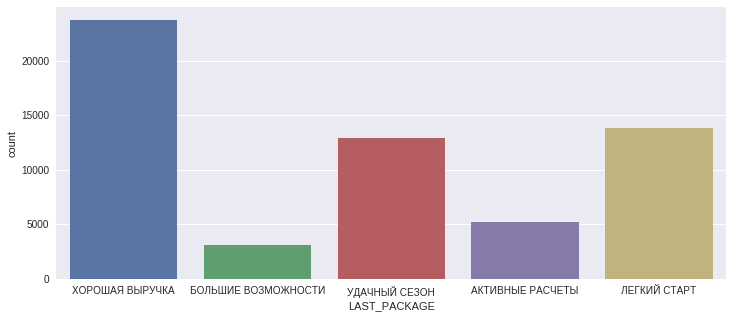

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(df['LAST_PACKAGE']);

The both training and validation sets must contain only 4 paid packages, so as to Sberbank interested in only predicting paid packages. Here we split data on test set called `left_out` with free package `ЛЕГКИЙ СТАРТ` and remaining dataset `df`, consisting of remaining packages. At the same time df is split on training (`X_train, y_train`) and validation (`X_test, y_test`) sets respectively.

In [16]:
left_out = df[df['LAST_PACKAGE'] == 'ЛЕГКИЙ СТАРТ']
df = df[df['LAST_PACKAGE'] != 'ЛЕГКИЙ СТАРТ']

In [17]:
df.drop('GOSB', axis=1, inplace=True)
df = df[df['TB'] != 'Центральный аппарат']

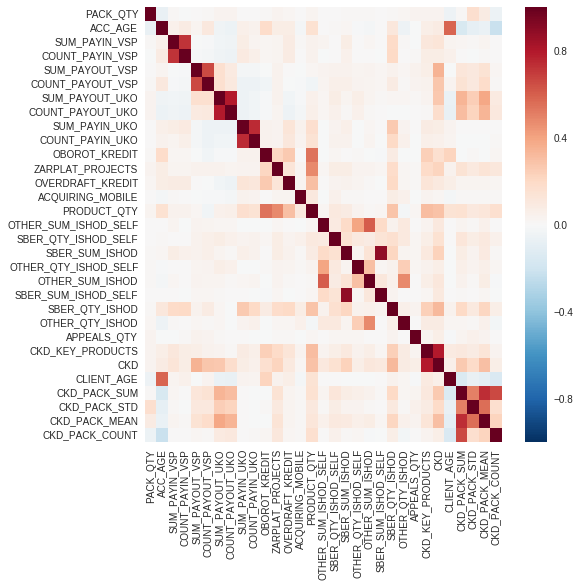

In [18]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr());

The following features should be ommited due to high correlation

In [19]:
df.drop(['SBER_SUM_ISHOD_SELF', 'CKD_KEY_PRODUCTS'], axis=1, inplace=True)

Unlike `R`, the features with type `object` should be transformed even for tree-based methods

In [24]:
encoder_TB = LabelEncoder()
encoder_TB.fit(df['TB'])
df['TB'] = encoder_TB.transform(df['TB'])

encoder_package = LabelEncoder()
encoder_package.fit(df['LAST_PACKAGE'])
df['LAST_PACKAGE'] = encoder_package.transform(df['LAST_PACKAGE'])

In [25]:
X = df.loc[:, ~df.columns.isin(['LAST_PACKAGE', 'INN', 'ACC'])]
y = df['LAST_PACKAGE']

Split dataset on training and validation sets, stratifying on packages

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=19)

Baseline equals to 0.53

In [27]:
y_test.value_counts().max()/y_test.value_counts().sum()

0.52892654107680304

A class distribution on the validation set

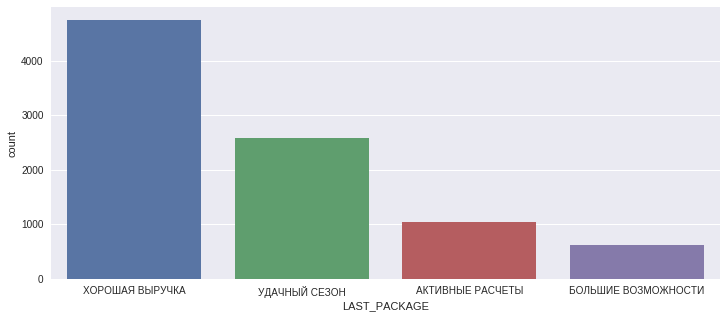

In [23]:
plt.figure(figsize=(12, 5))
sns.countplot(y_test);

Hereinafter, all models will be accompanied with 3 type of plots:
    1. Validation curve (determines training and test scores for varying parameter values)
    2. Learning curve (determines training and test scores for different training set sizes. It helps to determine whether addditional samples imporve accuracy or not)
    3. Feature importances (determines the most important features)

In [28]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1, 5), title=None, ylim=None, n_jobs=1):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim) # correct scale
        
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(b=True)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     alpha=0.1, color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     alpha=0.1, color='green')
    plt.plot(train_sizes, train_scores_mean, 'x-', color='red', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'x-', color='green', label='Cross-validation score')
    plt.legend(loc='best')

In [40]:
def plot_validation_curve(estimator, X, y, param_name, param_range, scoring, cv=5, title=None, ylim=None, xlim=None, n_jobs=1):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim) # correct scale
        
    plt.xlabel(param_name)
    plt.ylabel('Score')
    
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name,param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(b=True)
    
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     alpha=0.1, color='red')
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     alpha=0.1, color='green')
    plt.plot(param_range, train_scores_mean, 'x-', color='red', label='Training score')
    plt.plot(param_range, test_scores_mean, 'x-', color='green', label='Cross-validation score')
    
    plt.legend(loc='best')

In [30]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    indices = np.arange(len(X_train.columns))

    sorted_importances = pd.DataFrame({'importances': importances,
                                       'feature': X_train.columns}).sort_values('importances')

    plt.figure(figsize=(10, 10))
    plt.barh(indices, sorted_importances['importances'], color='g')
    plt.yticks(indices, sorted_importances['feature'])
    plt.ylabel('Features')
    plt.xlabel('Importances');
    plt.title('Feature importances');

### Tree

In [31]:
tree = DecisionTreeClassifier(max_depth=None, class_weight='balanced')
tree.fit(X_train, y_train)
tree_pred_train = tree.predict(X_train)
tree_pred_test = tree.predict(X_test)
print('train', accuracy_score(y_train, tree_pred_train))
print('test', accuracy_score(y_test, tree_pred_test))
print('max_depth', tree.tree_.max_depth)

train 1.0
test 0.866792999666
max_depth 31


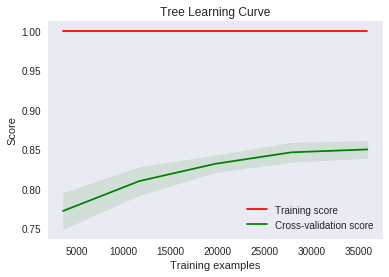

In [32]:
plot_learning_curve(tree, X, y, n_jobs=2, title='Tree Learning Curve')

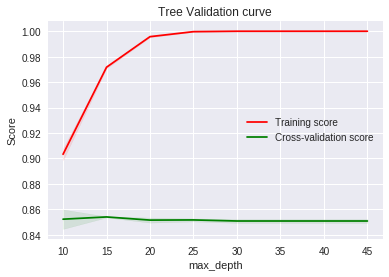

In [41]:
plot_validation_curve(tree, X, y, 'max_depth', np.arange(10, 50, 5), 'f1_weighted', cv=3, n_jobs=50,
                      title='Tree Validation curve')

### Random Forest

In [42]:
rf = RandomForestClassifier(n_estimators=2000, max_depth=None, class_weight='balanced', n_jobs=50)
rf.fit(X_train, y_train)
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)
print('train', accuracy_score(y_train, rf_pred_train))
print('test', accuracy_score(y_test, rf_pred_test))
print('test', f1_score(y_test, rf_pred_test, average='weighted'))
#print('depth of each tree', [estimator.tree_.max_depth for estimator in rf.estimators_])

train 1.0
test 0.891093523576
test 0.890321614379


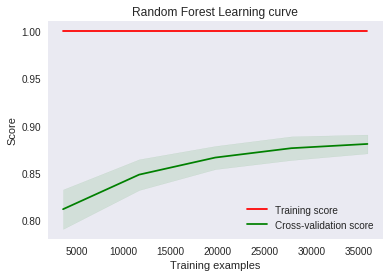

In [36]:
plot_learning_curve(rf, X, y, n_jobs=50, title='Random Forest Learning curve')

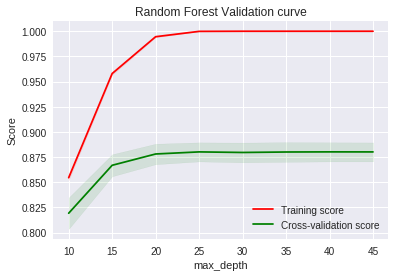

In [44]:
plot_validation_curve(rf, X, y, 'max_depth', np.arange(10, 50, 5), 'f1_weighted', cv=5, n_jobs=50,
                      title='Random Forest Validation curve')

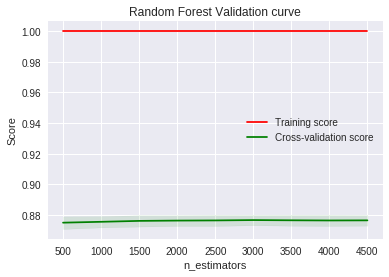

In [45]:
plot_validation_curve(rf, X, y, 'n_estimators', np.arange(500, 5000, 500), 'f1_weighted', cv=3, n_jobs=50,
                      title='Random Forest Validation curve')

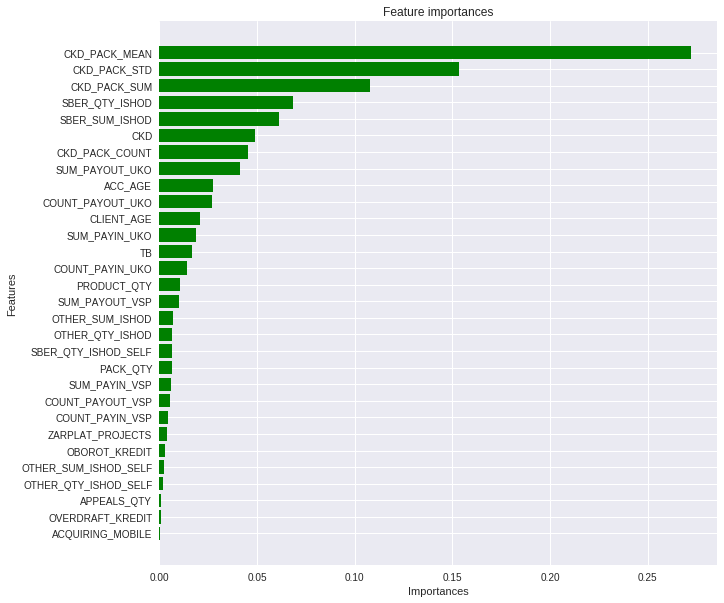

In [46]:
plot_feature_importances(rf)

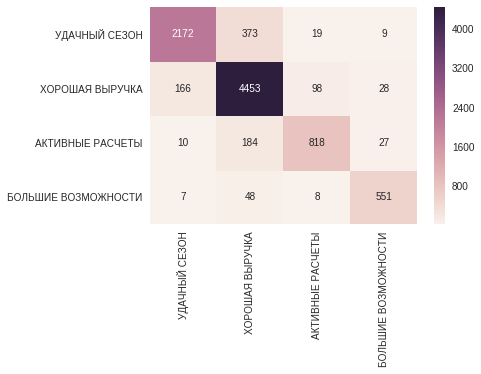

In [48]:
labs = [2,3,0,1] #conduct order
sns.heatmap(confusion_matrix(y_test, rf_pred_test, labels=labs), annot=True, fmt='d',
            yticklabels=encoder_package.inverse_transform(labs), xticklabels=encoder_package.inverse_transform(labs));

### Gradient Boosting

In [49]:
gb = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.1, max_depth=3)
gb.fit(X_train, y_train)
gb_pred_train = gb.predict(X_train)
gb_pred_test = gb.predict(X_test)
print('train', accuracy_score(y_train, gb_pred_train))
print('test', accuracy_score(y_test, gb_pred_test))
print('test', f1_score(y_test, gb_pred_test, average='weighted'))
gb_pred_test_proba = gb.predict_proba(X_test)
#print('depth of each tree', [estimator.tree_.max_depth for estimator in rf.estimators_])

train 0.998467155319
test 0.919852859213
test 0.919740497062


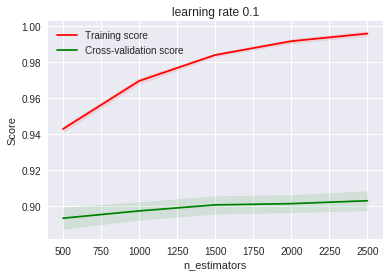

In [66]:
plot_validation_curve(gb, X, y, 'n_estimators', np.arange(500, 3000, 500), 'accuracy', cv=5, n_jobs=50,
                      title='learning rate 0.1')

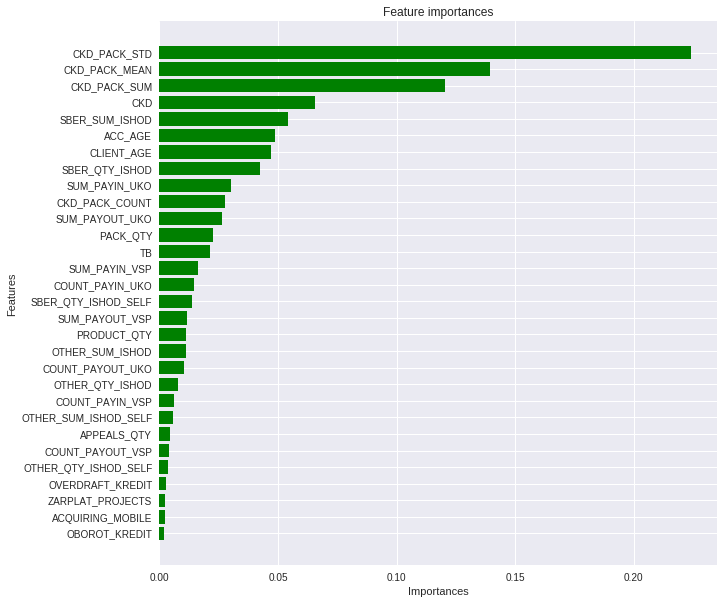

In [51]:
plot_feature_importances(gb)

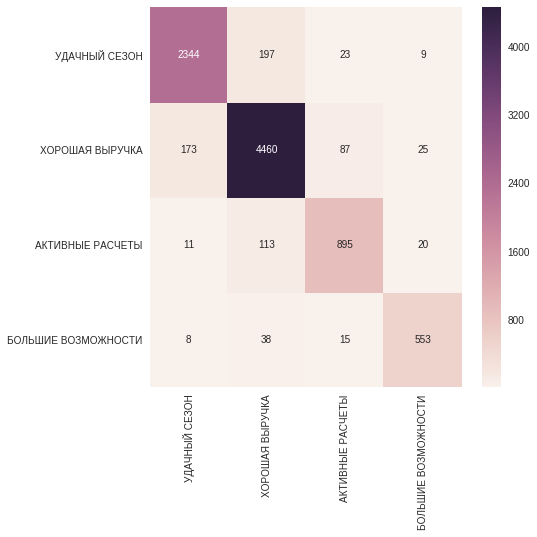

In [50]:
plt.figure(figsize=(7,7))
labs = [2,3,0,1]
sns.heatmap(confusion_matrix(y_test, gb_pred_test, labels=labs), annot=True, fmt='d', yticklabels=encoder_package.inverse_transform(labs), xticklabels=encoder_package.inverse_transform(labs)) 

### KNN

For implenementation minkowski metric with parameter `p=2`, the categorical feature `TB` should be deleted from dataframe 

In [52]:
continuous_df = df.drop('TB', axis=1)
continuous_X = continuous_df.loc[:, ~continuous_df.columns.isin(['LAST_PACKAGE', 'INN', 'ACC'])]
continuous_y = continuous_df['LAST_PACKAGE']

Continuous variables should be scaled to `mean=0` and `variance=1`

In [53]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(continuous_X))
scaled_y = continuous_y.reset_index(drop=True)

scaled_df = pd.concat([scaled_X, scaled_y], axis=1)

In [55]:
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(scaled_X, scaled_y, test_size=0.2,
                                                                                stratify=scaled_y, random_state=17)

In [56]:
knn = KNeighborsClassifier(n_neighbors=50, p=2)
knn.fit(scaled_X_train, scaled_y_train)
knn_pred_train = knn.predict(scaled_X_train)
knn_pred_test = knn.predict(scaled_X_test)
print('train', accuracy_score(scaled_y_train, knn_pred_train))
print('test', accuracy_score(scaled_y_test, knn_pred_test))

train 0.708815250411
test 0.692341990859


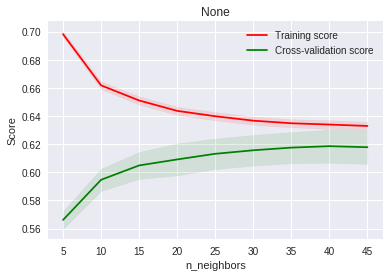

In [65]:
plot_validation_curve(knn, continuous_X, continuous_y, 'n_neighbors', np.arange(5, 50, 5), 'accuracy', cv=5, n_jobs=50)

### Left_out

The best model in terms of accuracy is Gradient Boosting. Now predict probabilities and the most likely package on the test (`left_out`) set.

In [57]:
left_out.drop('GOSB', axis=1, inplace=True)
left_out = left_out[left_out['TB'] != 'Центральный аппарат']
left_out.drop(['SBER_SUM_ISHOD_SELF', 'CKD_KEY_PRODUCTS'], axis=1, inplace=True)

left_out['TB'] = encoder_TB.transform(left_out['TB'])
left_out_X = left_out.loc[:, ~left_out.columns.isin(['LAST_PACKAGE', 'INN', 'ACC'])]

In [58]:
predicted_package = gb.predict(left_out_X)
predicted_package_proba = gb.predict_proba(left_out_X)

predicted_package = pd.Series(predicted_package, index=left_out_X.index, name='PREDICTED_PACKAGE')
predicted_package_proba = pd.Series(np.max(predicted_package_proba, axis=1), index=left_out_X.index,
                                    name='PROBABILITY_PACKAGE')

In [59]:
package = pd.concat([left_out, predicted_package, predicted_package_proba], axis=1)

In [60]:
package['TB'] = encoder_TB.inverse_transform(package['TB'])
package['PREDICTED_PACKAGE'] = encoder_package.inverse_transform(package['PREDICTED_PACKAGE'])

In [64]:
package.sample(3)

,INN,ACC,LAST_PACKAGE,PACK_QTY,TB,ACC_AGE,SUM_PAYIN_VSP,COUNT_PAYIN_VSP,SUM_PAYOUT_VSP,COUNT_PAYOUT_VSP,SUM_PAYOUT_UKO,COUNT_PAYOUT_UKO,SUM_PAYIN_UKO,COUNT_PAYIN_UKO,OBOROT_KREDIT,ZARPLAT_PROJECTS,OVERDRAFT_KREDIT,ACQUIRING_MOBILE,PRODUCT_QTY,OTHER_SUM_ISHOD_SELF,SBER_QTY_ISHOD_SELF,SBER_SUM_ISHOD,OTHER_QTY_ISHOD_SELF,OTHER_SUM_ISHOD,SBER_QTY_ISHOD,OTHER_QTY_ISHOD,APPEALS_QTY,CKD,CLIENT_AGE,CKD_PACK_SUM,CKD_PACK_STD,CKD_PACK_MEAN,CKD_PACK_COUNT,PREDICTED_PACKAGE,PROBABILITY_PACKAGE
36893,6012007570,40702810851140000973,ЛЕГКИЙ СТАРТ,1,Северо-Западный банк,3170,0.0,0,0.0,0,0.0,0,73100.0,8,0,0,0,0,3,0.0,0,6750.00,0,0.00,3,0,0.0,16536.78,3177,17280.0,0.000000,8640.0,2,БОЛЬШИЕ ВОЗМОЖНОСТИ,0.999964
26998,4825092842,40702810335000006100,ЛЕГКИЙ СТАРТ,1,Центрально-Черноземный банк,332,0.0,0,0.0,0,0.0,0,206000.0,12,0,0,0,0,2,0.0,0,344849.63,0,205018.63,25,7,0.0,8637.68,2120,7203.0,961.605948,1029.0,7,ХОРОШАЯ ВЫРУЧКА,0.838315
21496,3812130023,40702810118350025910,ЛЕГКИЙ СТАРТ,1,Байкальский банк,2324,4978000.0,71,0.0,0,0.0,0,18157100.0,522,0,0,0,0,4,0.0,237,34729000.00,0,20534301.60,237,711,0.0,158244.58,2955,17100.0,0.000000,1900.0,9,ХОРОШАЯ ВЫРУЧКА,0.993086


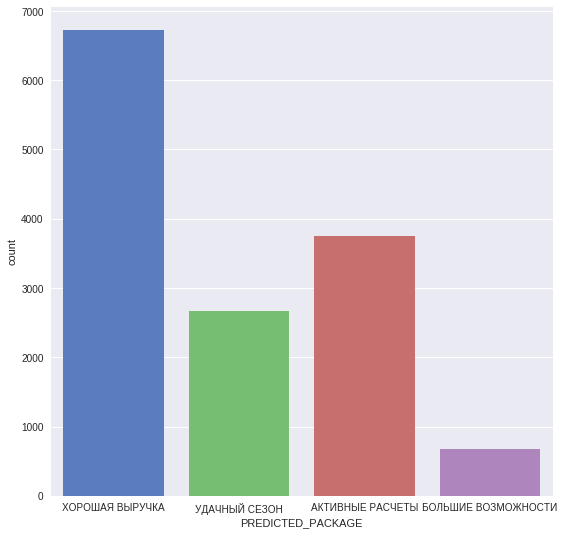

In [61]:
plt.figure(figsize=(9, 9))
sns.countplot(package['PREDICTED_PACKAGE'], palette='muted');